<a href="https://www.kaggle.com/code/ishaks2005/airfare-forecasting-system?scriptVersionId=253794054" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ✈️ Airfare Forecasting System
This notebook builds and tests several models to predict flight prices based on various features like airline, source, duration, stops, and more.

## 🔍 Objective
To predict the price of a flight using machine learning techniques on the dataset flight_data.


## 1. 📦 Importing Libraries
We begin by importing essential libraries for data manipulation, visualization, and modeling.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform

## 2. 🗂️ Loading Data
We load the data and take an initial look.

In [3]:
data = pd.read_csv('/kaggle/input/flight-data/flight_data.csv')

## 3. 📊 Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand its structure, uncover patterns, and identify any issues such as missing values, duplicates, or outliers.


### 📐  Shape and Structure of Data

- **Data Shape**: (4000 rows × 12 columns)
  

This gives us an idea of dataset size and dimensionality.

In [4]:
#Shape of data

data_shape = data.shape
print(f'Shape of training data : {data_shape}')

Shape of training data : (40000, 12)


### 🧾  Column Names and Data Types

We inspect the column names and check data types to identify categorical vs. numerical features. This also helps in planning preprocessing and encoding steps.

* Numerical columns: price, duration, days_left, flight_freq

* Categorical columns : stops, class, departure, arrival, airline, source, destination, flight


In [5]:
#Information on data and column datatypes

data_info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           40000 non-null  int64  
 1   airline      35387 non-null  object 
 2   flight       40000 non-null  object 
 3   source       40000 non-null  object 
 4   departure    35208 non-null  object 
 5   stops        37681 non-null  object 
 6   arrival      40000 non-null  object 
 7   destination  40000 non-null  object 
 8   class        40000 non-null  object 
 9   duration     36987 non-null  float64
 10  days_left    35562 non-null  float64
 11  price        40000 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 3.7+ MB


###  📊   Descriptive Statistics

Using `.describe()`, we look at:
- Mean, Count, Std, min, max, and percentiles of numerical features like `id`,`price`,`duration`, and `days_left`.The median values are shown in the 50% row.
- Presence of outliers (e.g., unusually high `price`)

In [6]:
#Descriptive Statistics

data.describe()

,id,duration,days_left,price
count,40000.00000,36987.000000,35562.000000,40000.00000
mean,19999.50000,12.004088,26.197936,20801.49025
std,11547.14972,7.108063,13.469232,22729.14842
min,0.00000,0.830000,1.000000,1105.00000
25%,9999.75000,6.670000,15.000000,4687.00000
50%,19999.50000,11.080000,26.000000,7353.00000
75%,29999.25000,15.920000,38.000000,42521.00000
max,39999.00000,47.080000,49.000000,114704.00000


### ❗ Missing Values

We check for missing values using `.isnull().sum()`. Handling these is essential before modeling, especially for features like `days_left`.


In [7]:
missing_values = data.isnull().sum()
print(f'Number of missing values corresponding to each column :\n {missing_values}')

Number of missing values corresponding to each column :
 id                0
airline        4613
flight            0
source            0
departure      4792
stops          2319
arrival           0
destination       0
class             0
duration       3013
days_left      4438
price             0
dtype: int64


### 🔁 Duplicate Records

We find and count duplicate rows **excluding the `id` column**, which is unique by design.

- Number of duplicated rows found: **250**

Duplicates can distort model training, so we drop them to ensure clean learning.


In [8]:
number_of_duplicates = data.duplicated(subset=[col for col in data.columns if col != 'id']).sum()
print(f'Number of Duplicated Rows : {number_of_duplicates}')

Number of Duplicated Rows : 250


### 📦 Outlier Detection Using Boxplots

To visually identify potential outliers in the dataset, we plotted boxplots for all numeric columns:

✅ Columns Visualized:

   `id`, `duration`, `days_left`, `price`

💡 **Insights:**

1. `id`:

* The id column appears uniformly distributed with no significant outliers.

* Since id is likely just a unique identifier, it's not useful for modeling and can be dropped.

2. `duration`:

* Shows a large number of high-end outliers.

* Some flight durations are significantly longer than the majority, which may be genuine long-haul flights or possible data entry errors.


3. `days_left`:

* The spread is reasonable with no clear outliers.

* Distribution seems fairly even — this feature is clean and useful for modeling.

4. `price`:

* The price column shows a clear right-skew with many outliers.

* These high-priced tickets could heavily influence model performance.

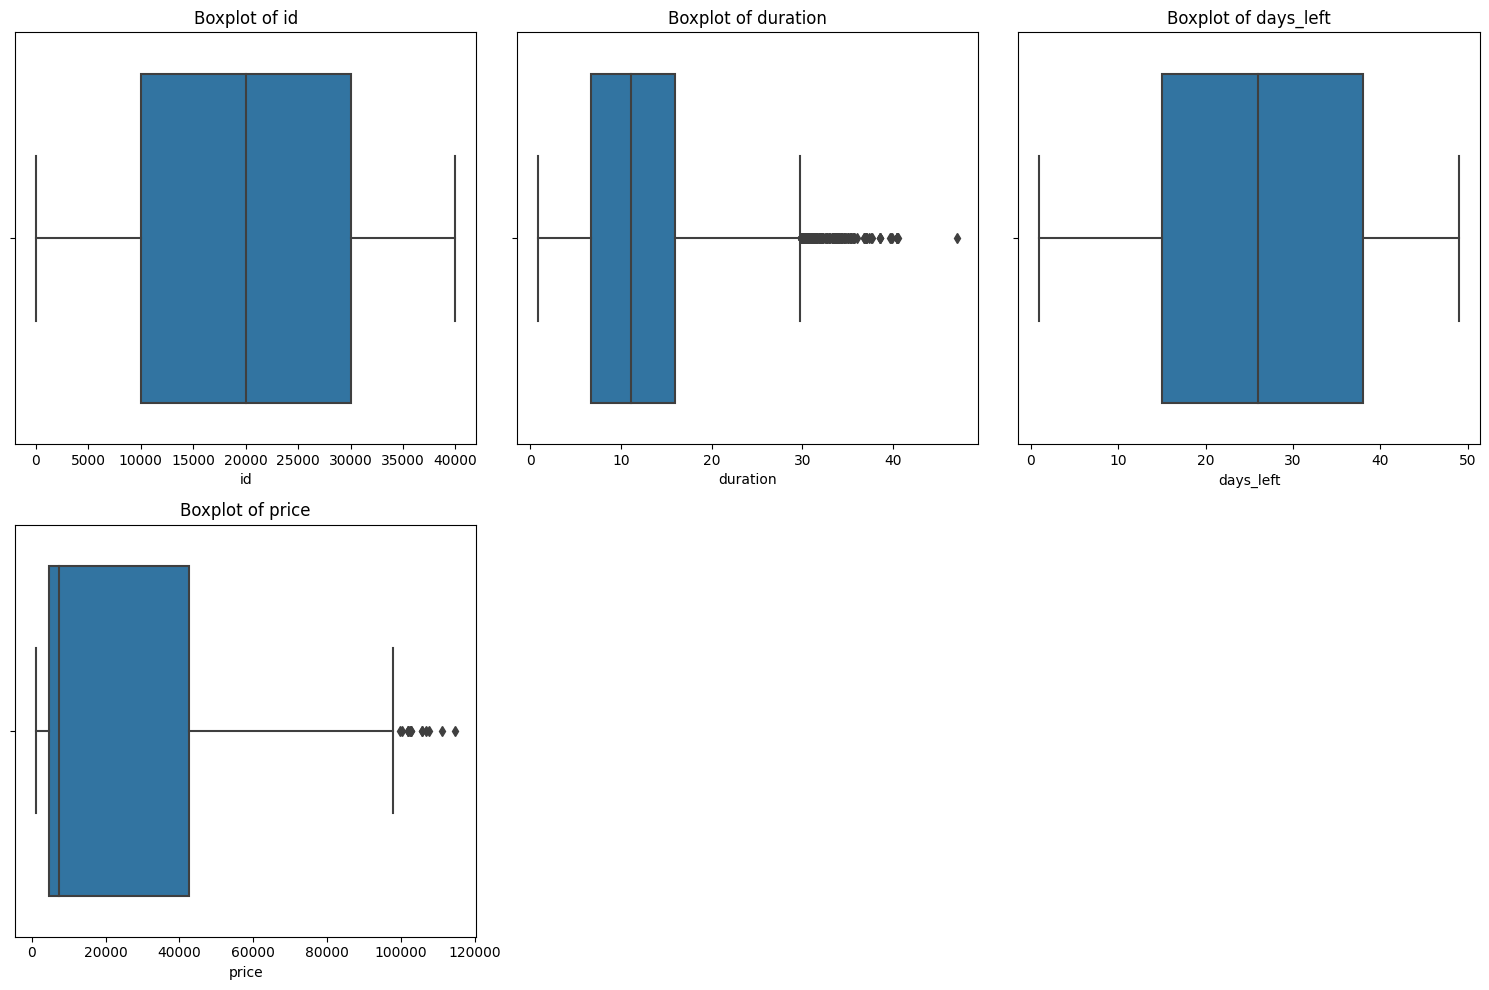

In [9]:
#Boxplot

numeric_cols = data.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


### 🌡️ Correlation Heatmap

We compute correlations between numerical features using `.corr()`.

💡 **Insights:**
 
1. **`duration` vs `price` → Positive Correlation (0.22):**  
   - As flight duration increases, the price tends to increase.  
   - This aligns with intuition — longer flights are generally more expensive due to fuel, service, and distance.

2. **`days_left` vs `price` → Negative Correlation (-0.093):**  
   - As the number of days left before departure increases, price tends to decrease.  
   - This supports real-world behavior: booking earlier usually results in cheaper fares.


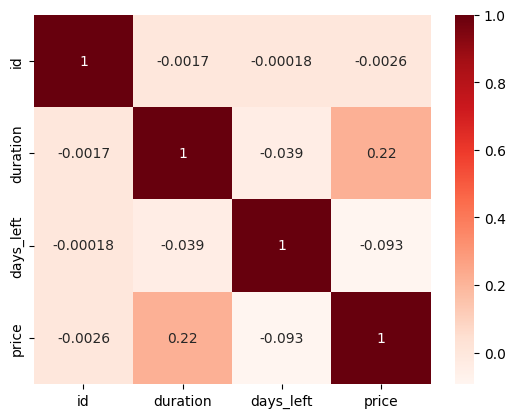

In [10]:
#Heatmap

numeric_cols = data.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix,cmap='Reds',annot=True)
plt.show()

### 🧮 Target Distribution (Histogram)

We visualize the distribution of `price`, the target variable.

💡 **Insights**:

* The `price` distribution is **right-skewed**, with most flights priced below ₹10,000.
* There are several high-priced outliers (business class or last-minute bookings).


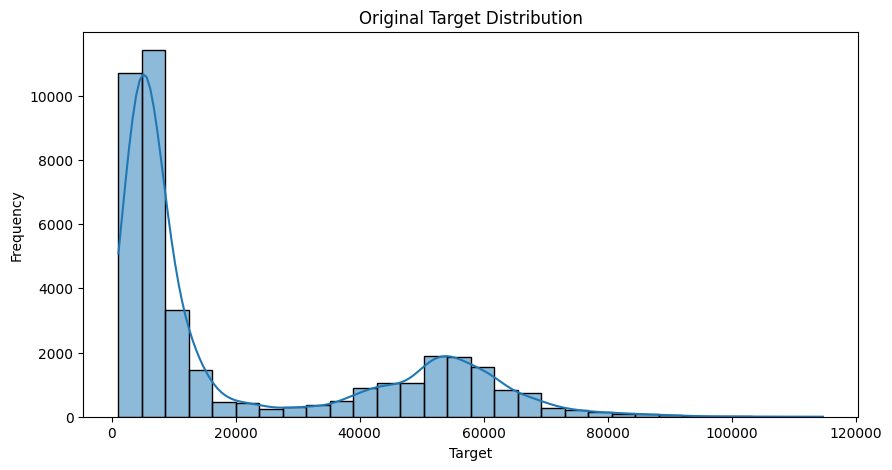

In [11]:
#Histogram

plt.figure(figsize=(10,5))
sns.histplot(data['price'], bins=30, kde=True)
plt.title("Original Target Distribution")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.show()

## 3. 🧹 Data Preprocessing

### ✅ Dropping Irrelevant Columns

* `id` column was dropped from both train and test sets as it provides no predictive value.

In [12]:
#Dropping irrelevant columns

data = data.drop('id',axis=1)

### 🔁 Duplicate Rows

* Although duplicate rows were detected in the dataset, they were intentionally not dropped. After experimentation, it was found that retaining the duplicates improved model performance (as measured by validation metrics).

* Hence, they were preserved to leverage potentially valuable signal in repeated patterns.

In [13]:
'''#Removing Duplicates

def remove_duplicates(data):
    cols_to_check = [col for col in data.columns]
    data_cleaned = data.drop_duplicates(subset=cols_to_check).reset_index(drop=True)
    return data_cleaned

print(f"Train data shape before removing duplicates : {data.shape}")

data = remove_duplicates(data)

print(f"Data shape after removing duplicates: {data.shape}")'''

'#Removing Duplicates\n\ndef remove_duplicates(data):\n    cols_to_check = [col for col in data.columns]\n    data_cleaned = data.drop_duplicates(subset=cols_to_check).reset_index(drop=True)\n    return data_cleaned\n\nprint(f"Train data shape before removing duplicates : {data.shape}")\n\ndata = remove_duplicates(data)\n\nprint(f"Data shape after removing duplicates: {data.shape}")'

### ✅ Adjusting flight Column

* Some flight values were in scientific notation — these were replaced with NaN for consistency.

In [14]:
#Adjusting flight column(removing scientific notations)

data['flight'] = data['flight'].replace(to_replace=r'^\d+\.\d+[eE][+-]?\d+$', value=np.nan, regex=True)

### 📈 Outlier Handling

* We capped outliers in price and duration using the IQR method:
* Outliers were replaced with these bounds to minimize distortion while preserving overall data distribution.

In [15]:
#Capping Outliers

def get_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

def cap_column(series, lower, upper):
    return np.where(series < lower, lower,
                    np.where(series > upper, upper, series))

columns_with_outliers = ['price', 'duration']  

for col in columns_with_outliers:
    lower, upper = get_iqr_bounds(data[col])
    data[col] = cap_column(data[col], lower, upper)

### 🎯 Feature & Target Separation 

The target variable for this task is `price`. All other relevant columns were selected as features.

In [16]:
# Feature-Target Separation

X_train_data = data.drop('price',axis=1)
y_train_data = data['price']

### 🪓 Train-Validation Split

The dataset was split into training, validation and test sets to evaluate model generalization.

In [17]:
#Train-Test-Validation Split

# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X_train_data, y_train_data, test_size=0.3, random_state=42)

# Second split: Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### 🔢 Feature Engineering

* The flight column contains a large number of unique values, making it a high-cardinality categorical feature. Traditional one-hot encoding would result in a very sparse and high-dimensional dataset, which can negatively impact model performance and training time.

* To address this, we applied frequency encoding, where each flight is replaced by the number of times it appears in the dataset.

In [18]:
#Frequency Encoding

flight_freq = X_train['flight'].value_counts(normalize=True)

for df in [X_train,X_val,X_test]:
    df['flight_freq'] = df['flight'].map(flight_freq).fillna(0)
    df.drop('flight', axis=1, inplace=True)

### 🔄 Preprocessing Pipeline

To prepare the dataset for modeling, we implemented customized preprocessing pipelines tailored to the nature of each feature and the requirements of different algorithms. This section outlines how we handled missing values, encoded categorical variables, and scaled features.

* Airline:

    * Used `SimpleImputer(strategy='most_frequent')` because airline names are categorical and often repeated.

   *  Applied `OrdinalEncoder()` to convert airline names to numeric form suitable for models without inflating feature space.

* Numerical Columns (duration, days_left, flight_freq):

    * Used `median` strategy to handle skewed numerical distributions robustly.
  
    * Applied `StandardScaler()` (in scaled pipeline) to normalize values for models sensitive to scale (e.g., linear models).

* Ordinal Columns (stops, class, arrival, departure):

    * Used `most_frequent` as these are categorical and missingness often implies repetition.

    * Used `OrdinalEncoder` with domain-specific category order (e.g., class: Economy < Business) to preserve ordinal relationship.

* One-Hot Columns (source, destination):

    * Used `most_frequent` due to high likelihood of repetition in categories. 

    * Used `OneHotEncoder(drop='first')` to avoid dummy variable trap and handle categorical data without implied order


* ColumnTransformer 

    Combined all pipelines into a unified `ColumnTransformer` to preprocess different column types in parallel.

   - `preprocessor_non_scaled`: For models that don’t require feature scaling.
      
   - `preprocessor_scaled`: For models that benefit from scaled numerical inputs (e.g., linear regreesion).

In [19]:
#Pipeline

num_missing_cols = ['duration','days_left','flight_freq']
one_hot_cols = ['source','destination']
ordinal_cols = ['stops','class','arrival','departure']
all_numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
ordinal_map = [
    ['zero', 'one', 'two_or_more'],  
    ['Economy', 'Business'],        
    ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night'],  # for 'departure'
    ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']   # for 'arrival'
]

airline_pipeline = Pipeline([
    ('airline_imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('num_imputer',SimpleImputer(strategy='median'))
])

num_pipeline_scaled = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline([
    ('ordinal_impute',SimpleImputer(strategy='most_frequent')),
    ('ordinal_encode',OrdinalEncoder(categories=ordinal_map))
])

one_hot_pipeline = Pipeline([
    ('one_hot_impute',SimpleImputer(strategy='most_frequent')),
    ('one_hot_encode',OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor_non_scaled = ColumnTransformer([
    ('airline_label', airline_pipeline, ['airline']),
    ('numerical',num_pipeline,num_missing_cols),
    ('ordinal_encoding',ordinal_pipeline,ordinal_cols),
    ('one-hot-encoding',one_hot_pipeline,one_hot_cols)
], remainder='passthrough')

preprocessor_scaled = ColumnTransformer([
    ('airline_label', airline_pipeline, ['airline']),
    ('numerical', num_pipeline_scaled, all_numeric_cols),  
    ('ordinal_encoding', ordinal_pipeline, ordinal_cols),
    ('one-hot-encoding', one_hot_pipeline, one_hot_cols)
], remainder='passthrough')

## 4.🧠 Model Building, Tuning, and Evaluation

### 🏗️  Model Building
- A total of **8 different regression models** were trained on the data:
  - Linear Regression
  - Extra Trees Regressor
  - SGD Regressor  
  - Random Forest  
  - Gradient Boosting  
  - XGBoost  
  - LightGBM  
  - K-Nearest Neighbors (KNN)

Each model was wrapped in a pipeline that included preprocessing specific to its requirements (scaled vs. non-scaled).


In [20]:
#Defining Models

models = {
    "Linear Regression": LinearRegression(),
    "SGD Regression": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42,verbose=-1),
    "KNN Regression": KNeighborsRegressor(),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    
}

### 🎯  Hyperparameter Tuning
- **RandomizedSearchCV** was used to tune hyperparameters for the following 3 models:
  
  - **Random** **Forest**: Tuned `n_estimators` and `max_depth`
     
  - **XGBoost**: Tuned `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `colsample_bytree`
    
  - **LightGBM**: Tuned the same hyperparameters as XGBoost for fairness in comparison

In [21]:
#Hyperparameter Tuning

param_distributions = {
    "Random Forest": {
        "model__n_estimators": randint(50, 200),
        "model__max_depth": randint(3, 20)
    },
    "XGBoost": {
        "model__n_estimators": randint(50, 200),
        "model__max_depth": randint(3, 20),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__subsample": uniform(0.6, 0.4),           
        "model__colsample_bytree": uniform(0.6, 0.4)
    },
    "LightGBM": {
        "model__n_estimators": randint(50, 200),
        "model__max_depth": randint(3, 20),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__subsample": uniform(0.6, 0.4),           
        "model__colsample_bytree": uniform(0.6, 0.4)
    }
}

# Only tune these models
models_to_tune = ["Random Forest", "XGBoost", "LightGBM"]

for name in models_to_tune:
    print(f"Tuning {name}...")
    
    preprocessor = preprocessor_non_scaled  

    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', models[name])
    ])
    
    search = RandomizedSearchCV(
        pipeline,
        param_distributions[name],
        n_iter=10,
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=0,
        random_state=42,
        n_jobs=1
    )
    
    search.fit(X_train, np.log1p(y_train))
    best_pipeline = search.best_estimator_
    
    # Update model with best model for use in evaluation
    models[name] = best_pipeline.named_steps['model']

Tuning Random Forest...
Tuning XGBoost...
Tuning LightGBM...


### 📊  Model Evaluation

- All trained models were evaluated on the validation set using the following metrics:
  
  - **R² Score**
    
  - **Root Mean Squared Error (RMSE)**
 
    
  - **Mean Absolute Error (MAE)**

Predictions were log-transformed during training and inverse-transformed before evaluation.

The results were compiled in a dataframe and sorted by **R² Score** for comparison.

In [22]:
#Training and Prediction on Evaluation set

results = []

tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM','Extra Trees']

for name, model in models.items():
    if name in tree_models:
        preprocessor = preprocessor_non_scaled
    else:
        preprocessor = preprocessor_scaled

    full_pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    full_pipeline.fit(X_train, np.log1p(y_train))
    preds_log = full_pipeline.predict(X_val)

    # Inverse log transform
    preds = np.expm1(preds_log)

    results.append({
        "Model": name,
        "R2 Score": r2_score(y_val, preds),
        "RMSE": np.sqrt(mean_squared_error(y_val, preds)),
        "MAE": mean_absolute_error(y_val, preds)
    })

results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
display(results_df.reset_index(drop=True))

,Model,R2 Score,RMSE,MAE
0,XGBoost,0.978556,3322.904040,1793.068890
1,Random Forest,0.975715,3536.195929,1909.006083
2,Extra Trees,0.975295,3566.659599,1695.083238
3,LightGBM,0.970722,3882.757057,2194.565435
4,Gradient Boosting,0.950858,5030.331623,2907.872116
5,Linear Regression,0.877377,7946.106891,4653.121727
6,SGD Regression,0.875276,8013.899661,4716.375307
7,KNN Regression,0.847636,8857.478448,4777.639207


### 📊 Model Comparison (Validation Set)

Multiple regression models were evaluated on the **validation set** using R² score to select the best-performing algorithm. This avoids data leakage and ensures fair comparison.

#### 🏁 Compared Models:
Linear Regression, KNN, Random Forest, Extra Trees, Gradient Boosting, LightGBM, XGBoost, SGD Regressor

#### 🏆 Best Performer:
**XGBoost** with **R² = 0.97**, significantly outperforming KNN (**R² = 0.83**)


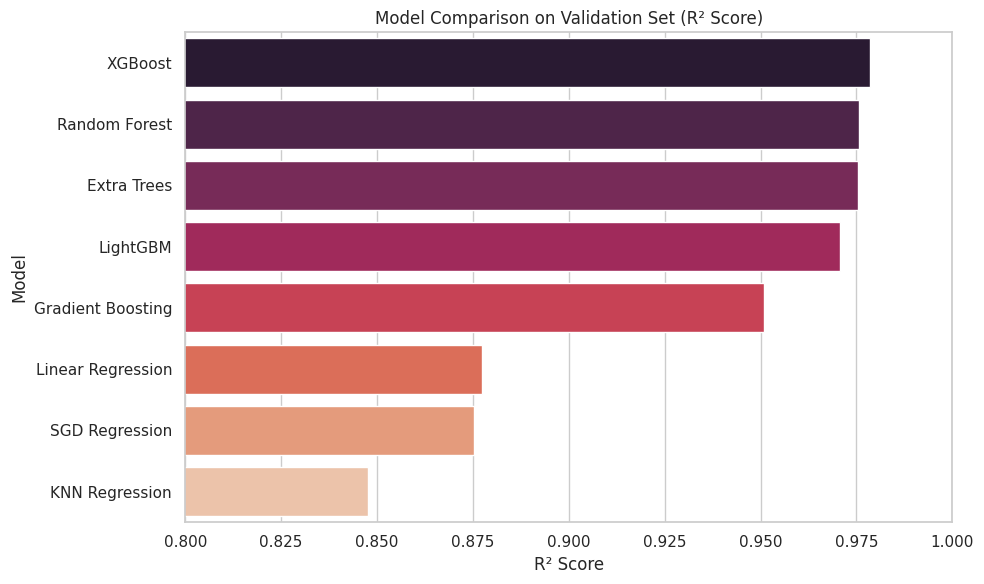

In [23]:
# Model Performance Analysis

sns.set(style="whitegrid")

# Sort by R² Score
performance_df = results_df.sort_values(by="R2 Score", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=performance_df, x="R2 Score", y="Model", palette="rocket")
plt.title("Model Comparison on Validation Set (R² Score)", fontsize=12)
plt.xlabel("R² Score")
plt.xlim(0.8, 1.0)
plt.tight_layout()
plt.show()

### 🏁  Final Model Selection and Submission

- The **best-performing model** on the validation set was selected based on R² score.
  
- This model was retrained on the combined training and validation set (`X_full`, `y_full`).

- Final predictions were made on the test set.


In [24]:
# Combining train set and val set
X_full = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)


#Using best model for test prediction
final_results = []

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print("Best Model:",best_model_name)

if best_model_name in ('Linear Regression','SGD Regression','KNN Regression'):
    final_pipeline = Pipeline([
        ('preprocess', preprocessor_scaled),
        ('model', best_model)
    ])
else:
    final_pipeline = Pipeline([
        ('preprocess', preprocessor_non_scaled),
        ('model', best_model)
    ])
    
final_pipeline.fit(X_full, np.log1p(y_full))
y_test_pred_log = final_pipeline.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

final_results.append({
        "Model": best_model_name,
        "R2 Score": r2_score(y_test, y_test_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "MAE": mean_absolute_error(y_test, y_test_pred)
 })

final_results_df = pd.DataFrame(final_results)
display(final_results_df)

Best Model: XGBoost


,Model,R2 Score,RMSE,MAE
0,XGBoost,0.980305,3186.310514,1708.511666
